In [1]:
import bz2
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = './data'
september_dataset = os.path.join(DATA_PATH, '09_prepared.pkl.bz2')
october_dataset = os.path.join(DATA_PATH, '10_prepared.pkl.bz2')
november_dataset = os.path.join(DATA_PATH, '11_prepared.pkl.bz2')

In [3]:
def read_whole_dataset(file_paths):
    dfs = []
    for path in file_paths:
        with bz2.open(path, 'rb') as file:
            df = pickle.load(file)
        dfs.append(df)
    return pd.concat(dfs)

In [4]:
df = read_whole_dataset([september_dataset, october_dataset, november_dataset])
df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
0,2020-09-01 17:01:25,0E05D308-5CEC-EA11-B444-005056A7539A,0,8594499,52,271,1.0,108.00,False,1538855,1283228
1,2020-09-01 17:35:36,610205A1-61EC-EA11-B444-005056A7539A,0,1452388,52,271,1.0,108.00,False,267307,8873113
2,2020-09-01 19:19:21,8AF19602-70EC-EA11-B444-005056A7539A,0,3493538,52,271,1.0,107.95,False,610220,12712899
3,2020-09-01 21:53:34,EB6C71A3-84EC-EA11-B444-005056A7539A,0,2491281,52,271,1.0,108.00,False,441497,21535283
4,2020-09-01 18:42:31,0706023F-6BEC-EA11-B444-005056A7539A,0,5732396,61,97,2.0,88.00,False,1065358,642341


In [5]:
outliers_set = set()

### Consider id_cards with both negative sum and quantity as outliers

In [6]:
def negative_sum_and_quantity(df):
    res_df = df[(df['sum'] < 0) | (df['quantity'] < 0)]
    outlier_ids = set(res_df.id_card_int.unique())
    return res_df, outlier_ids

In [7]:
res_df, res_outliers = negative_sum_and_quantity(df)
res_df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
4206092,2020-09-04 09:10:21,827B9591-75EE-EA11-B444-005056A7539A,0,7009929,23074,19269,1.268,-470.43,False,1301664,11939194
4206093,2020-09-04 09:10:21,827B9591-75EE-EA11-B444-005056A7539A,0,7009929,23074,19269,-1.268,470.43,False,1301664,11939194
4206102,2020-09-04 09:09:24,F6807973-75EE-EA11-B444-005056A7539A,0,7707981,23074,19269,1.268,-470.43,False,1419650,22549976
4206103,2020-09-04 09:09:24,F6807973-75EE-EA11-B444-005056A7539A,0,7707981,23074,19269,-1.268,470.43,False,1419650,22549976
4210123,2020-09-04 08:37:00,49C21AF5-70EE-EA11-B444-005056A7539A,0,5554550,23074,19269,-1.084,402.16,False,1035577,6745380


In [8]:
print("Number of outliers found:", len(res_outliers))
outliers_set = outliers_set.union(res_outliers)

Number of outliers found: 58


### Find out some unspecific conditions of outliers

Consider the case of sum=0.

In [9]:
res_df = df[df['sum'] == 0.0].sort_values('quantity', ascending=False)
res_df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
38495700,2020-11-25 16:27:11,9FBB1558-232F-EB11-B444-005056A7539A,0,0046993,1113,-9999,5000.0,0.0,False,10316,14613425
15356470,2020-10-11 16:09:22,6177CCB2-C30B-EB11-B444-005056A7539A,0,5994929,1113,-9999,5000.0,0.0,False,1113028,8915494
38253498,2020-10-26 19:17:31,E31D1D9C-A817-EB11-B444-005056A7539A,0,7309000,1113,-9999,5000.0,0.0,False,1353783,20775007
38251372,2020-10-26 20:09:39,BB417D7A-AE17-EB11-B444-005056A7539A,0,9359646,1113,-9999,5000.0,0.0,False,1625679,17129548
33258970,2020-09-24 12:12:31,A66163E3-46FE-EA11-B444-005056A7539A,0,5707080,1113,-9999,5000.0,0.0,False,1061019,15221182


There are some transactions with `id_kontr` being -9999 (those, None) and having equal `quantity`=5000. Let's consider these transactions and their id_cards as outliers.

In [10]:
print('Number of suspicious transactions:', 
      len(df[(df['sum'] == 0.0)&(df['quantity'] == 5000)]))
print('Number of suspicious cards:', 
      len(df[(df['sum'] == 0.0)&(df['quantity'] == 5000)].id_card_int.unique()))

Number of suspicious transactions: 3298
Number of suspicious cards: 1698


In [11]:
res_outliers = set(df[(df['sum'] == 0.0)&(df['quantity'] == 5000)].id_card_int.unique())
outliers_set = outliers_set.union(res_outliers)

### Find out some unspecific conditions of outliers #2

Let's find out the richest people in our dataset and filter them out.

In [12]:
res_df = df.groupby('id_card_int', as_index=False)['sum'].sum().sort_values('sum', ascending=False)
res_df.head()

,id_card_int,sum
883386,883386,60016231.51
1577248,1577248,1279932.55
568930,568930,379927.61
1028081,1028081,292730.00
497966,497966,284392.33


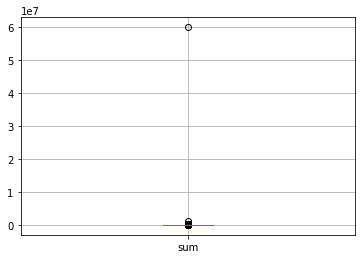

In [13]:
res_df.iloc[:][['sum']].boxplot();

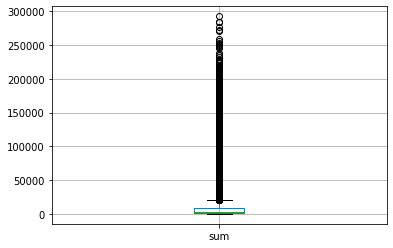

In [14]:
res_df.iloc[3:][['sum']].boxplot();

But there are also situations when a customer has total `sum` equal 0. This is also strange situation and they may be considered as outliers.

In [15]:
res_df.sort_values('sum').head()

,id_card_int,sum
405371,405371,0.0
1838463,1838463,0.0
1666204,1666204,0.0
1084788,1084788,0.0
1880405,1880405,0.0


Finally, let's find out the outliers. Let's not remove much rich people (just the most obvious samples).

In [16]:
res_outliers = set(res_df[(res_df['sum'] > 300000)&(res_df['sum'] == 0)]['id_card_int'].unique())
outliers_set = outliers_set.union(res_outliers)

### Filter out id_cards having orders with abnormal sum

In [17]:
res_df = df.groupby(['id_doc', 'id_card_int'], as_index=False)['sum'].sum()
res_df.head()

,id_doc,id_card_int,sum
0,0000007F-811F-EB11-B444-005056A7539A,457312,274.0
1,000001CD-E807-EB11-B444-005056A7539A,50796,790.0
2,00000230-16FC-EA11-B444-005056A7539A,1425208,396.0
3,00000233-3315-EB11-B444-005056A7539A,1164741,228.0
4,00000292-91FE-EA11-B444-005056A7539A,1438933,1597.0


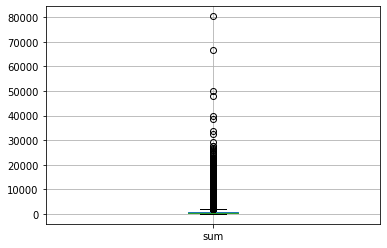

In [18]:
res_df[['sum']].boxplot();

Let's define the threshold to be 30000.

In [20]:
res_outliers = set(res_df[res_df['sum'] > 30000]['id_card_int'].unique())
outliers_set = outliers_set.union(res_outliers)

### Too frequent purchases

In [24]:
df['day'] = df['date'].dt.date

Let's consider that customers usually don't go to the shop too often - (for this experiment) no more than once per day.

In [25]:
res_df = df.groupby('id_card_int', as_index=False)['day'].nunique().sort_values('day', ascending=False)
res_df.head()

MemoryError: Unable to allocate 3.01 GiB for an array with shape (3, 134720638) and data type object

In [ ]:
res_df[['day']].boxplot();

In [ ]:
res_outliers = set(res_df[res_df['day'] > 30]['id_card_int'].unique())
outliers_set = outliers_set.union(res_outliers)

### Finalize and save results

In [21]:
print('Total number of outliers:', len(outliers_set))

Total number of outliers: 1759


In [22]:
res_df = pd.DataFrame(outliers_set, columns=['susp_id_card_int'])

In [23]:
RESULT_PATH = './susp_id_card_int_res.pkl.bz2'

with bz2.open(RESULT_PATH, 'wb') as file:
    pickle.dump(res_df, file, protocol=4)